# Wall avoidance

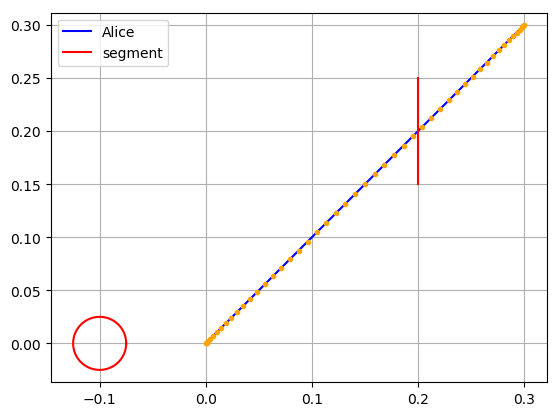

Optimal
Total energy: 238.04081632653066
Meeting location: (0.3, 0.3)


In [121]:
using JuMP, PyPlot, Ipopt

# Define model, variables, constraints, objective
m = Model(solver=IpoptSolver(print_level=0))

time = 50
start = [0, 0]
finish = [0.3, 0.3]
#time_step = 36
circles = [-0.1 0]
#             0.1 0;
#             -0.1 0.1;
#             0.1 0.1
#             0.15 0.2;
#             -0.05 0.2;
#             0.2 0.3;
#             0 0.3;
#             0.3 0.4;
#             0.1 0.4;
#             0.4 0.5;
#             0.2 0.5]

segment = [0.2 0.2;
         0.15 0.25]

r = 0.025

num_circles, dim = size(circles)

@variable(m, x_A[1:2, 1:time])
@variable(m, v_A[1:2, 1:time])
@variable(m, u_A[1:2, 1:time])

# x index on east/west, y index on north/south
@constraint(m, x_A[:, 1] .== start) # Alice's initial position
@constraint(m, v_A[:, 1] .== [0, 0]) # Alice's initial velocity 

# Keep path away from obstacles defined by radii from circle center
for t in 1:time
    for c in 1:num_circles
    @NLconstraint(m, (x_A[1,t]-circles[c,1])^2 + (x_A[2,t]-circles[c,2])^2  >= (r + r/10)^2) 
    end
end

# # Keep path away from line segments
# # TODO: incorporate conditional constraints to prevent x_A from crossing segment

# a = [segment[1],segment[2]]
# b = [segment[3],segment[4]]
# for t in 1:time-1
#     c = [x_A[1,t], x_A[2,t]]
#     d = [x_A[1,t+1], x_A[2,t+1]]
#     if (intersect(a,b,c,d))
#        println("cross") 
#     end
# end

# Dynamic equations
for t in 1:time-1
    @constraint(m, x_A[:, t+1] .== x_A[:, t] + (1/3600)*v_A[:, t]) # Alice's position    
    @constraint(m, v_A[:, t+1] .== v_A[:, t] + u_A[:, t]) # Alice's velocity
end

@constraint(m, x_A[:, time] .== finish) # final location
@constraint(m, v_A[:, time] .== [0,0]) # final velocity

# Adds up euclidian distance between each time step
#d_tot = @NLexpression(m, d_tot^2, sum{ (x_A[1,t+1]-x_A[1,t])^2 + (x_A[2,t+1]-x_A[2,t])^2, t=1:time-1} )  

#@NLobjective(m, Min, d_tot)
@objective(m, Min, sum(u_A.^2)) # minimize total energy

# Solve
status = solve(m)
println(status)

#d_tot_actual = 0
# for t in 1:time-1
#    d_tot_actual += sqrt( (getvalue(x_A[1,t+1])-getvalue(x_A[1,t]))^2 + (getvalue(x_A[2,t+1])-getvalue(x_A[2,t]))^2) 
# end

#println("d_tot_actual: ", d_tot_actual)

# Printing all values for d_tot
# for t in 1:time-1
#     println(t," ",sqrt( (getvalue(x_A[1,t+1])-getvalue(x_A[1,t]))^2 + (getvalue(x_A[2,t+1])-getvalue(x_A[2,t]))^2 ))
# end

# Output
x_A = getvalue(x_A)
println("Total energy: ", getobjectivevalue(m))
println("Meeting location: (", x_A[1,time],", ",x_A[2,time],")")

# Graph path
plot(x_A[1, :], x_A[2, :], color="blue", label="Alice")
#plot(x_A[1, time_step], x_A[2, time_step], ".", color="orange")

# Plot circle
t = range(0,stop=2pi,length=100)         # parameter that traverses the circle
for c in 1:num_circles
    plot( circles[c,1] .+ r*cos.(t), circles[c,2] .+ r*sin.(t), color="red")  # plot circle radius r with center (x1, x2)
end

# Plot segment
plot(segment[1,:], segment[2,:], color="red", label="segment")


# Plot time steps
for t in 1:time
   plot(x_A[1, t], x_A[2, t], ".", color="orange")
end

# Keep path away from line segments
# a = [segment[1],segment[2]]
# b = [segment[3],segment[4]]
# for t in 1:time-1
#     c = [x_A[1,t], x_A[2,t]]
#     d = [x_A[1,t+1], x_A[2,t+1]]
#     println("c: ",c)
#     println("d: ",d)
#     println(intersect(a,b,c,d),"\n")
# end

# Formatting
axis("equal")                            # make x and y scales equal
grid("on")
legend()
;

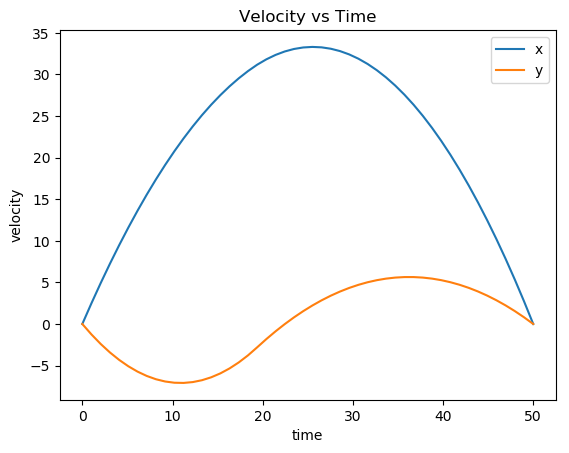

In [4]:
# Velocity plot
x = range(0, stop=time, length=time)
plot(x[:], getvalue(v_A)[1,:], label="x" )
plot(x[:], getvalue(v_A)[2,:], label="y" )
title("Velocity vs Time")
xlabel("time")
ylabel("velocity")
legend()
;

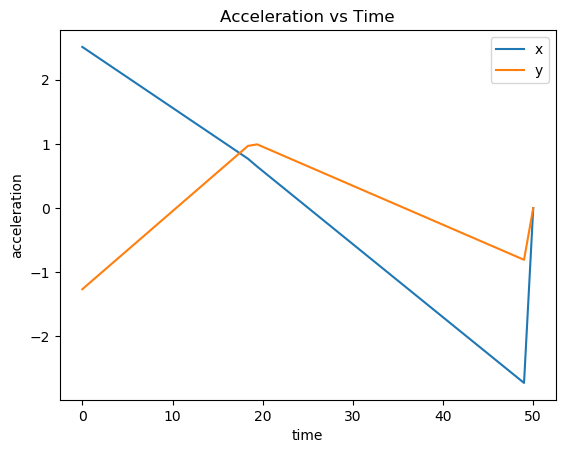

In [5]:
# Acceleration plot
x = range(0, stop=time, length=time)
plot(x[:], getvalue(u_A)[1,:], label="x" )
plot(x[:], getvalue(u_A)[2,:], label="y" )
title("Acceleration vs Time")
xlabel("time")
ylabel("acceleration")
legend()
;

In [90]:
function point_on_segment(a, b, c)
    # a and b end points of a segment, c point to check
    # only gets called if c is determined by orientation(a,b,c) to be collinear with ab
    # returns true if c on segment ab, false otherwise 
    if ( min(a[1], b[1]) <= c[1] && c[1] <= max(a[2], b[2]) )
        if ( min(a[2], b[2]) <= c[2] && c[2] <= max(a[2], b[2]) )
        return true
        end
    end
    return false
end

point_on_segment (generic function with 1 method)

In [114]:
function orientation(a, b, c)
    # a and b end points of a segment, c point to check
    
    #slope1 = (b[2]-a[2])/(b[1]-a[1])
    #slope2 = (c[2]-b[2])/(c[1]-b[1])
    #val = slope1 - slope2
    
    val = (b[2]-a[2])*(c[1]-b[1]) - (c[2]-b[2])*(b[1]-a[1])
    println("val: ",val)
    if(val<0)
        return 1 # clockwise
    end
    if(val>0)
        return 2 # counterclockwise 
    end
    return 0 # slopes the same
    
end

orientation (generic function with 1 method)

In [92]:
function intersect(a, b, c, d)
    # a and b existing segment, c and d segment to check
    # returns true if intersection discovered, false otherwise
    
    # ab vs new segment test
    ab_vs_c = orientation(a,b,c)
    ab_vs_d = orientation(a,b,d)
    
    # new segment vs ab test
    cd_vs_a = orientation(c,d,a)
    cd_vs_b = orientation(c,d,b)
    
    # if both orientation tests are different, then segments cross 
    if(ab_vs_c != ab_vs_d && cd_vs_a != cd_vs_b)
        return true
    end
    
    # verify any collinearity does not result in crossing
    
    # c collinear with ab
    if(ab_vs_c == 0 && point_on_segment(a,b,c))
        return true
    end
    
    # d collinear with ab
    if(ab_vs_d == 0 && point_on_segment(a,b,d))
        return true
    end
    
    # a collinear with cd
    if(cd_vs_a == 0 && point_on_segment(c,d,a))
        return true
    end
    
    # b collinear with cd
    if(cd_vs_b == 0 && point_on_segment(c,d,b))
        return true
    end
    
    # if crossing not detected, return false
    return false   
    
end

intersect (generic function with 1 method)

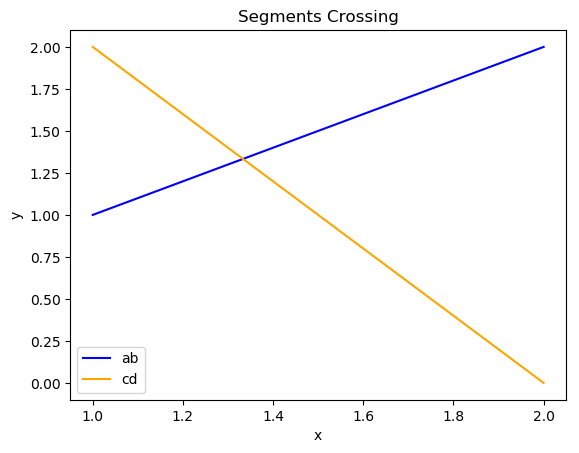

true


In [93]:
# Testing segment crossing
a = [1 1] # left point of ab
b = [2 2] # right point of ab
c = [2 0] # left point of cd
d = [1 2] # right point of cd

# segment ab
line1 = [a[1] b[1];
         a[2] b[2]]
# segment cd
line2 = [c[1] d[1];
         c[2] d[2]]

# Plot segments
plot(line1[1,:], line1[2,:], color="blue", label="ab")
plot(line2[1,:], line2[2,:], color="orange", label="cd")

title("Segments Crossing")
xlabel("x")
ylabel("y")
legend()

println(intersect(a,b,c,d)) # determine if points cross or not and print result
;